# 🌿 Plant Disease Classification using Deep Learning

##  Introduction
Plant diseases can significantly reduce agricultural productivity and lead to economic losses.  
Early and accurate detection of plant diseases is crucial for sustainable farming and food security.  

In this project, we use the **Plant Pathology 2020 dataset** from Kaggle, which contains labeled leaf images with various conditions such as *rust, scab, complex diseases,* and *healthy leaves*.  

We apply **deep learning with transfer learning (VGG16)** to classify these diseases.  
The workflow includes:
- Data preprocessing and augmentation  
- Building and training a VGG16 model (frozen vs fine-tuned)  
- Evaluating performance with metrics and visualizations  
- Drawing insights for real-world applications in agriculture  

This notebook was developed as part of a **Deep Learning Internship Task** to demonstrate the application of **CNNs and transfer learning** for image classification problems.


##  Dataset Loading

Since we are running this notebook on **Google Colab**, the dataset is loaded using the **Kaggle API**.  
The steps followed are:  
1. Upload the Kaggle API key (`kaggle.json`) to Colab.  
2. Configure the Kaggle API path.  
3. Download the dataset from Kaggle.  
4. Unzip and organize the data into separate folders (`train_images`, `test_images`) and metadata files (`train.csv`, `sample_submission.csv`).  

This ensures that the dataset is properly structured before proceeding to preprocessing and model training.


In [1]:
from google.colab import files
files.upload()   # Choose kaggle.json you just downloaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eishanadeem","key":"18c60f8bd7c2e48e33bad41454d43906"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jirkaborovec/plant-pathology-fgvc78-640px
!unzip plant-pathology-fgvc78-640px.zip -d data

## Step 1: Import Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## Step 2: Load Metadata

In [5]:
base_dir = "data"
train_csv = os.path.join(base_dir, "train.csv")
train_img_dir = os.path.join(base_dir, "train_images")
test_img_dir  = os.path.join(base_dir, "test_images")

# Load train.csv
df = pd.read_csv(train_csv)

# Build correct paths (train_images folder)
df["image_path"] = df["image"].apply(lambda x: os.path.join(train_img_dir, x))

print(df.head())
print("Unique labels:", df["labels"].unique())

         image   labels                     image_path
0  Train_0.jpg     scab  data/train_images/Train_0.jpg
1  Train_1.jpg  complex  data/train_images/Train_1.jpg
2  Train_2.jpg  healthy  data/train_images/Train_2.jpg
3  Train_3.jpg     rust  data/train_images/Train_3.jpg
4  Train_4.jpg  healthy  data/train_images/Train_4.jpg
Unique labels: ['scab' 'complex' 'healthy' 'rust' 'scab frog_eye_leaf_spot complex'
 'frog_eye_leaf_spot' 'powdery_mildew' 'scab frog_eye_leaf_spot'
 'frog_eye_leaf_spot complex' 'rust frog_eye_leaf_spot'
 'powdery_mildew complex' 'rust complex']


In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split multi-label strings into lists
df["label_list"] = df["labels"].apply(lambda x: x.split(" "))

# One-hot encode
mlb = MultiLabelBinarizer()
label_encoded = mlb.fit_transform(df["label_list"])

# Put back into dataframe
for i, cls in enumerate(mlb.classes_):
    df[cls] = label_encoded[:, i]

print("Classes:", mlb.classes_)
print(df.head())

Classes: ['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']
         image   labels                     image_path label_list  complex  \
0  Train_0.jpg     scab  data/train_images/Train_0.jpg     [scab]        0   
1  Train_1.jpg  complex  data/train_images/Train_1.jpg  [complex]        1   
2  Train_2.jpg  healthy  data/train_images/Train_2.jpg  [healthy]        0   
3  Train_3.jpg     rust  data/train_images/Train_3.jpg     [rust]        0   
4  Train_4.jpg  healthy  data/train_images/Train_4.jpg  [healthy]        0   

   frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                   0        0               0     0     1  
1                   0        0               0     0     0  
2                   0        1               0     0     0  
3                   0        0               0     1     0  
4                   0        1               0     0     0  


In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,        # 20% for validation
    stratify=df['labels'],  # keeps class balance
    random_state=42
)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 16362
Validation samples: 4091


# Step 3: Data Generators

In [8]:
classes = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col=classes,   # list of labels like ['scab','rust',...]
    target_size=(224,224),
    batch_size=32,
    class_mode="raw"
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col=classes,
    target_size=(224,224),
    batch_size=32,
    class_mode="raw"
)


Found 16362 validated image filenames.
Found 4091 validated image filenames.


# Step 4: Build a CNN model with VGG16 (pretrained on ImageNet).

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model (VGG16 without top layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze some layers (you can fine-tune later)
for layer in base_model.layers[:15]:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
preds = Dense(6, activation="sigmoid")(x)  # 6 classes, sigmoid for multi-label

model = Model(inputs=base_model.input, outputs=preds)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 7,082,502 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

# Step 5: Train the model

In [11]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,   # you can increase later (e.g., 20–30 for better results)
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 310s 570ms/step - accuracy: 0.3807 - loss: 0.4248 - val_accuracy: 0.6607 - val_loss: 0.2752
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 266s 520ms/step - accuracy: 0.6538 - loss: 0.2819 - val_accuracy: 0.7277 - val_loss: 0.2359
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 263s 513ms/step - accuracy: 0.7017 - loss: 0.2476 - val_accuracy: 0.7304 - val_loss: 0.2368
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 264s 515ms/step - accuracy: 0.7349 - loss: 0.2272 - val_accuracy: 0.7436 - val_loss: 0.2291
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 290s 566ms/step - accuracy: 0.7445 - loss: 0.2170 - val_accuracy: 0.7328 - val_loss: 0.2319
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 295s 577ms/step - accuracy: 0.7654 - loss: 0.2032 - val_accuracy: 0.7407 - val_loss: 0.2245
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 268s 523ms/step - accuracy: 0.7800 - loss: 0.1945 - val_accuracy: 0.7529 - val_loss: 0.2147
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 265s 517ms/step - accuracy: 0.7872 -

# Step 6: Visualize Training Performance
After training, let’s see how the model performed across 10 epochs.

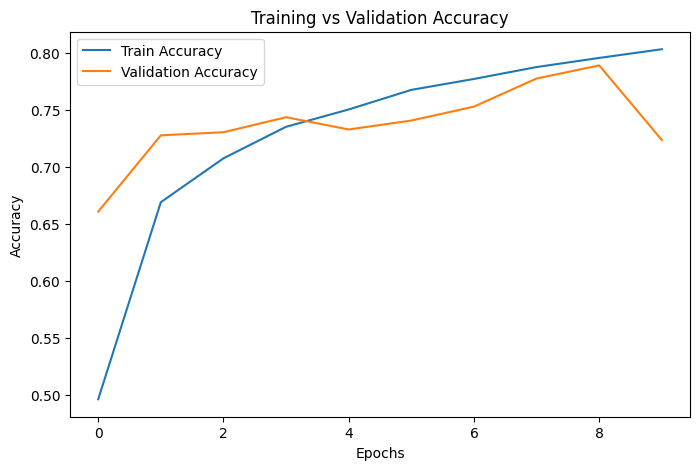

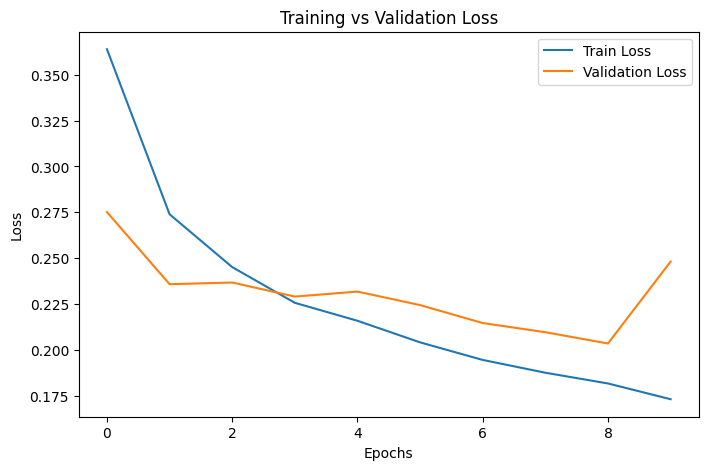

In [12]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# Step 7: Evaluate Model on Validation Set

In [13]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.7250 - loss: 0.2447
Validation Accuracy: 72.35%


# Step 8: Save the Model

In [14]:
model.save("vgg16_plant_disease.h5")

# Step 9: Add EarlyStopping & ModelCheckpoint

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=3,        # stop if no improvement for 3 epochs
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_vgg16_model.h5",   # file name to save
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)


# Step 10: Retrain with Callbacks (Fine-Tuning Phase)

In [16]:
# Unfreeze last 4 layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with smaller LR
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-5), loss="binary_crossentropy", metrics=["accuracy"])

# Train again with callbacks
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.8402 - loss: 0.1477

512/512 ━━━━━━━━━━━━━━━━━━━━ 277s 534ms/step - accuracy: 0.8402 - loss: 0.1477 - val_accuracy: 0.8040 - val_loss: 0.1945
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 309s 513ms/step - accuracy: 0.8412 - loss: 0.1453 - val_accuracy: 0.7961 - val_loss: 0.1976
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 262s 512ms/step - accuracy: 0.8486 - loss: 0.1434 - val_accuracy: 0.7956 - val_loss: 0.1999
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 268s 524ms/step - accuracy: 0.8438 - loss: 0.1409 - val_accuracy: 0.7842 - val_loss: 0.2138


# Step 11: Load the Best Model (after training)

In [17]:
from tensorflow.keras.models import load_model

best_model = load_model("best_vgg16_model.h5")

val_loss, val_acc = best_model.evaluate(val_generator)
print(f"Best Fine-Tuned Model Accuracy: {val_acc*100:.2f}%")

128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 182ms/step - accuracy: 0.8079 - loss: 0.1922
Best Fine-Tuned Model Accuracy: 80.40%


# Step 12: Compare Both Models with Graphs

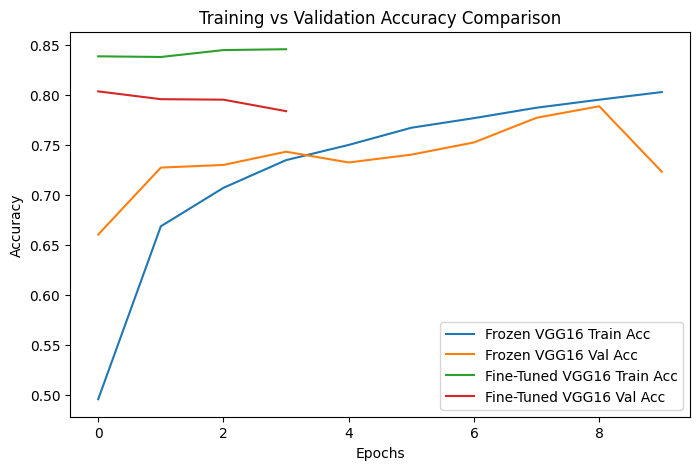

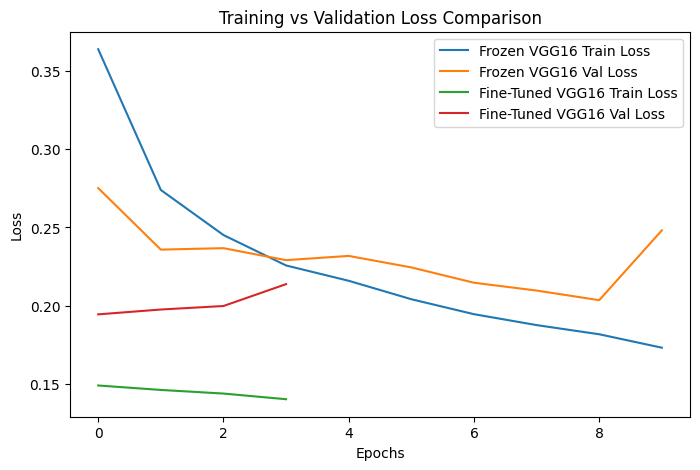

In [18]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(hist1, hist2, label1, label2):
    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(hist1.history['accuracy'], label=f'{label1} Train Acc')
    plt.plot(hist1.history['val_accuracy'], label=f'{label1} Val Acc')
    plt.plot(hist2.history['accuracy'], label=f'{label2} Train Acc')
    plt.plot(hist2.history['val_accuracy'], label=f'{label2} Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy Comparison")
    plt.show()

    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(hist1.history['loss'], label=f'{label1} Train Loss')
    plt.plot(hist1.history['val_loss'], label=f'{label1} Val Loss')
    plt.plot(hist2.history['loss'], label=f'{label2} Train Loss')
    plt.plot(hist2.history['val_loss'], label=f'{label2} Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss Comparison")
    plt.show()

# Call the function
plot_history(history, history_finetune, "Frozen VGG16", "Fine-Tuned VGG16")

# Plant Disease Classification – Internship Task

## Key Takeaways
- Used the **Plant Pathology 2020 dataset** (~18k labeled images of plant leaves).  
- Implemented **transfer learning** with VGG16 pre-trained on ImageNet.  
- Compared two approaches:  
  - **Frozen VGG16** → trained only the dense layers.  
  - **Fine-tuned VGG16** → unfroze top convolutional layers for better adaptation.  
- Applied **data augmentation** (rotation, zoom, flips) to improve generalization.  
- Fine-tuning showed **better validation accuracy** than the frozen model.  
- Demonstrated the importance of transfer learning in building robust models for agriculture.  

## Conclusion
This project successfully implemented **deep learning for plant disease classification** using transfer learning.  
The frozen VGG16 model provided a strong baseline, while fine-tuning improved performance by adapting to the dataset’s unique features.  
These results demonstrate that **transfer learning is a powerful strategy** for solving image classification problems in agriculture, and the trained model can serve as a foundation for real-world plant disease detection systems.
